In [ ]:
import numpy as np

## 1. Configuração do Spark

In [ ]:
!pip install pyspark

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType, IntegerType, ArrayType

In [ ]:
spark = SparkSession \
    .builder \
    .appName("ButinaClustering") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

## 2. Estabelecer indivíduos

In [ ]:
qtd_individuos = 20
qtd_caracteristicas = 10
np.random.seed(32)

In [ ]:
## Criação de indivíduos. Serão criados X individuos, de acordo com o valor 'qtd_individuos' estabelecido; cada um com Y de características, de acordo com 'qtd_caracteristicas'.
# Foi estabelecida uma seed para garantir reprodutibilidade.
# Em "np.random.randint(0, 2, qtd_caracteristicas)", são gerados valores inteiros no intervalo de 0 (inclusivo) a 2 (exclusivo), resultando em vetores compostos apenas por 0 e 1, na quantidade estabelecida em 'qtd_caracteristicas'.

individuos = [(i, np.random.randint(0, 2, qtd_caracteristicas).tolist())
  for i in range(qtd_individuos)]

In [ ]:
df_individuos = spark.createDataFrame(individuos, ["id", "caracteristicas"])
df_individuos.show(truncate=False)

+---+------------------------------+
|id |caracteristicas               |
+---+------------------------------+
|0  |[1, 1, 1, 0, 0, 0, 0, 1, 0, 1]|
|1  |[0, 1, 1, 1, 0, 1, 0, 1, 1, 1]|
|2  |[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]|
|3  |[0, 1, 1, 1, 0, 1, 1, 0, 1, 0]|
|4  |[0, 1, 0, 1, 0, 1, 0, 1, 0, 0]|
|5  |[0, 0, 0, 1, 0, 0, 1, 0, 1, 0]|
|6  |[1, 1, 0, 1, 0, 1, 1, 1, 1, 1]|
|7  |[1, 1, 0, 0, 1, 1, 1, 0, 0, 0]|
|8  |[0, 0, 1, 1, 0, 0, 0, 0, 0, 1]|
|9  |[0, 0, 1, 0, 1, 0, 1, 1, 0, 0]|
|10 |[0, 0, 0, 1, 1, 1, 1, 0, 0, 1]|
|11 |[1, 0, 1, 1, 0, 0, 0, 0, 0, 0]|
|12 |[1, 0, 0, 1, 0, 0, 1, 1, 0, 1]|
|13 |[1, 1, 0, 0, 1, 0, 0, 1, 0, 0]|
|14 |[0, 0, 1, 0, 0, 0, 0, 1, 0, 1]|
|15 |[0, 0, 0, 1, 0, 0, 1, 0, 1, 1]|
|16 |[0, 1, 1, 0, 1, 0, 1, 0, 1, 1]|
|17 |[1, 0, 1, 1, 0, 1, 1, 0, 0, 1]|
|18 |[0, 0, 1, 0, 1, 1, 1, 0, 0, 1]|
|19 |[0, 0, 1, 1, 1, 0, 0, 0, 1, 1]|
+---+------------------------------+



## 3. Cálculo das distâncias/similaridade (Índice de Tanimoto)

Nessa etapa do projeto, me ocorreu uma dúvida. A explicação em sala da similaridade entre os indivíduos, até onde lembro, considerava quando os dois indivíduos possuíam valor 1 e também quando possuíam valor 0; era uma similaridade geral. Porém ao ler sobre o índice de Tanimoto no artigo Butina(1999), no apêndice 2, ele define a fórmula do índice como:

> Tanimoto = BC/(B1 + B2 - BC); onde:

> B1 é a quantidade de 1 em F1; B2 é a quantidade de 1 em F2 e BC é a quantidade total de 1 em comum entre F1 e F2.

Nesse caso, não conta quando há a similaridade de 0s.

Procurei outro exemplo para confirmação, e no artigo de Kristensen, Nielsen e Pedersen (2010 - link: https://www.researchgate.net/publication/40846565_A_tree-based_method_for_the_rapid_screening_of_chemical_fingerprints) há uma imagem (Figura 1) com um exemplo de cálculo de índice de Tanimoto, em que também não há utilização da similaridade de 0s:


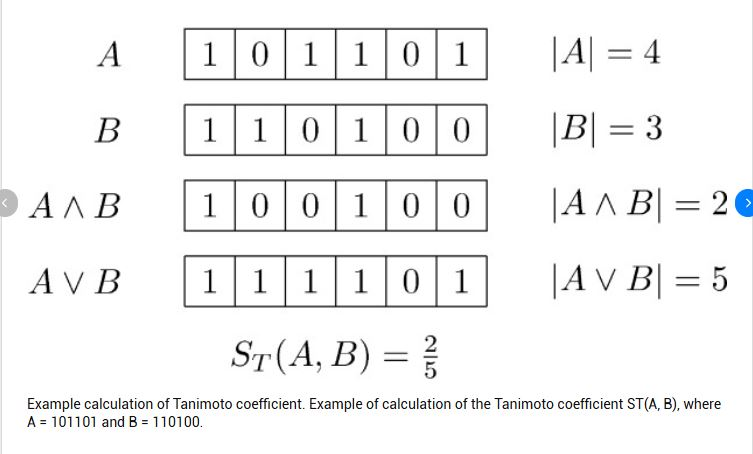

<a href="https://www.researchgate.net/figure/Example-calculation-of-Tanimoto-coefficient-Example-of-calculation-of-the-Tanimoto_fig6_40846565"><img src="https://www.researchgate.net/publication/40846565/figure/fig6/AS:282026340044802@1444251727106/Example-calculation-of-Tanimoto-coefficient-Example-of-calculation-of-the-Tanimoto.png" alt="Example calculation of Tanimoto coefficient. Example of calculation of the Tanimoto coefficient ST(A, B), where A = 101101 and B = 110100."/></a>

Com isso, continuarei com o desenvolvimento do projeto seguindo o artigo, considerando apenas a similaridade entre valores iguais a 1.

In [ ]:
## Definição da função com índice de Tanimoto

def tanimoto(a, b):
  a = np.array(a)
  b = np.array(b)
  inter = np.sum((a == 1) & (b == 1))
  union = np.sum((a == 1) | (b == 1))
  return float(inter / union) if union != 0 else 0.0

In [ ]:
# Função transformada em uma UDF do Spark, para execução paralela em pares de indivíduos.

udf_tanimoto = udf(tanimoto, FloatType())

## 4. Matriz de similaridade

In [ ]:
pares = df_individuos.alias("a").crossJoin(df_individuos.alias("b")) \
    .where(col("a.id") < col("b.id")) \
    .withColumn("similaridade", udf_tanimoto(col("a.caracteristicas"), col("b.caracteristicas"))) \
    .select(
        col("a.id").alias("a_id"),
        col("a.caracteristicas").alias("a_caracteristicas"),
        col("b.id").alias("b_id"),
        col("b.caracteristicas").alias("b_caracteristicas"),
        col("similaridade")
    )



pares.cache()
pares.show(20)

+----+--------------------+----+--------------------+------------+
|a_id|   a_caracteristicas|b_id|   b_caracteristicas|similaridade|
+----+--------------------+----+--------------------+------------+
|   0|[1, 1, 1, 0, 0, 0...|   1|[0, 1, 1, 1, 0, 1...|         0.5|
|   0|[1, 1, 1, 0, 0, 0...|   2|[1, 0, 1, 0, 0, 0...|         0.4|
|   0|[1, 1, 1, 0, 0, 0...|   3|[0, 1, 1, 1, 0, 1...|  0.22222222|
|   0|[1, 1, 1, 0, 0, 0...|   4|[0, 1, 0, 1, 0, 1...|   0.2857143|
|   0|[1, 1, 1, 0, 0, 0...|   5|[0, 0, 0, 1, 0, 0...|         0.0|
|   0|[1, 1, 1, 0, 0, 0...|   6|[1, 1, 0, 1, 0, 1...|  0.44444445|
|   0|[1, 1, 1, 0, 0, 0...|   7|[1, 1, 0, 0, 1, 1...|        0.25|
|   0|[1, 1, 1, 0, 0, 0...|   8|[0, 0, 1, 1, 0, 0...|  0.33333334|
|   0|[1, 1, 1, 0, 0, 0...|   9|[0, 0, 1, 0, 1, 0...|   0.2857143|
|   1|[0, 1, 1, 1, 0, 1...|   2|[1, 0, 1, 0, 0, 0...|       0.125|
|   1|[0, 1, 1, 1, 0, 1...|   3|[0, 1, 1, 1, 0, 1...|       0.625|
|   1|[0, 1, 1, 1, 0, 1...|   4|[0, 1, 0, 1, 0, 1...|   0.5714

## 5. Contagem de Vizinhos

In [ ]:
# Definição do nível de similaridade desejado
similaridade = 0.5

In [ ]:
# Seleção de vizinhos, para manter apenas os pares considerados semelhantes de acordo com o nível estabelecido

vizinhos = pares.filter(col("similaridade") >= similaridade)

In [ ]:
vizinhos.show()

+----+--------------------+----+--------------------+------------+
|a_id|   a_caracteristicas|b_id|   b_caracteristicas|similaridade|
+----+--------------------+----+--------------------+------------+
|   0|[1, 1, 1, 0, 0, 0...|   1|[0, 1, 1, 1, 0, 1...|         0.5|
|   1|[0, 1, 1, 1, 0, 1...|   3|[0, 1, 1, 1, 0, 1...|       0.625|
|   1|[0, 1, 1, 1, 0, 1...|   4|[0, 1, 0, 1, 0, 1...|   0.5714286|
|   1|[0, 1, 1, 1, 0, 1...|   6|[1, 1, 0, 1, 0, 1...|   0.6666667|
|   3|[0, 1, 1, 1, 0, 1...|   5|[0, 0, 0, 1, 0, 0...|         0.5|
|   3|[0, 1, 1, 1, 0, 1...|   6|[1, 1, 0, 1, 0, 1...|   0.5555556|
|   4|[0, 1, 0, 1, 0, 1...|   6|[1, 1, 0, 1, 0, 1...|         0.5|
|   0|[1, 1, 1, 0, 0, 0...|  13|[1, 1, 0, 0, 1, 0...|         0.5|
|   0|[1, 1, 1, 0, 0, 0...|  14|[0, 0, 1, 0, 0, 0...|         0.6|
|   1|[0, 1, 1, 1, 0, 1...|  19|[0, 0, 1, 1, 1, 0...|         0.5|
|   2|[1, 0, 1, 0, 0, 0...|  11|[1, 0, 1, 1, 0, 0...|   0.6666667|
|   3|[0, 1, 1, 1, 0, 1...|  16|[0, 1, 1, 0, 1, 0...|         

In [ ]:
# Conta quantos vizinhos cada indivíduo tem
count_a = vizinhos.groupBy(col("a_id").alias("id")) \
.count()


count_b = vizinhos.groupBy(col("b_id").alias("id")) \
.count()


count_vizinhos = count_a.union(count_b) \
.groupBy("id") \
.sum("count") \
.withColumnRenamed("sum(count)", "qtd_vizinhos")


count_vizinhos = count_vizinhos.fillna(0)

In [ ]:
# Ordena os indivíduos com mais vizinhos

count_vizinhos.orderBy(col("qtd_vizinhos").desc()).show()

+---+------------+
| id|qtd_vizinhos|
+---+------------+
| 17|           7|
|  6|           6|
|  1|           5|
|  3|           5|
| 15|           5|
|  8|           4|
| 19|           4|
| 18|           4|
|  0|           3|
| 10|           3|
| 12|           3|
| 11|           3|
| 16|           3|
|  5|           2|
|  4|           2|
| 13|           2|
| 14|           2|
|  7|           1|
|  9|           1|
|  2|           1|
+---+------------+



## 6. Montar os Clusters

In [ ]:
# Coleta ordenada (apenas IDs e contagens)
ordenado = count_vizinhos.orderBy(col("qtd_vizinhos").desc()).collect()

In [ ]:
vizinhos.printSchema()


root
 |-- a_id: long (nullable = true)
 |-- a_caracteristicas: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- b_id: long (nullable = true)
 |-- b_caracteristicas: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- similaridade: float (nullable = true)



In [ ]:
# Criação de um dicionário com os indivíduos e seus vizinhos
similaridade_map = {}

for row in vizinhos.collect():
  a = row["a_id"]
  b = row["b_id"]
  similaridade_map.setdefault(a, set()).add(b)
  similaridade_map.setdefault(b, set()).add(a)

In [ ]:
print(similaridade_map)

{0: {1, 13, 14}, 1: {0, 3, 4, 6, 19}, 3: {1, 5, 6, 16, 17}, 4: {1, 6}, 6: {1, 3, 4, 12, 15, 17}, 5: {3, 15}, 13: {0, 7}, 14: {0, 8}, 19: {8, 1, 16, 15}, 2: {11}, 11: {8, 17, 2}, 16: {19, 18, 3}, 17: {3, 6, 8, 10, 11, 12, 18}, 15: {5, 6, 10, 12, 19}, 12: {17, 6, 15}, 7: {13}, 8: {19, 17, 11, 14}, 9: {18}, 18: {16, 9, 10, 17}, 10: {17, 18, 15}}


In [ ]:
# Criação dos Clusters
clusters = []

# Indivíduos já utilizados que não podem virar centróides
flagged = set()

In [ ]:
for row in ordenado:
    centro_id = row['id']

    if centro_id in flagged:
        continue

    cluster = {centro_id}

    for n in similaridade_map.get(centro_id, []):
        if n not in flagged:
            cluster.add(n)

    clusters.append((centro_id, cluster))
    flagged.update(cluster)


In [ ]:
clusters_finais = []
singletons = set()

for centroide, elementos in clusters:
    if len(elementos) == 1:
        singletons.update(elementos)
    else:
        clusters_finais.append((centroide, elementos))

In [ ]:
print("Clusters encontrados:")
for i, (centroide, elementos) in enumerate(clusters_finais, start=1):
    print(f"Cluster {i} (centróide = {centroide}): {sorted(elementos)}")

print("\nSingletons:", sorted(singletons))


Clusters encontrados:
Cluster 1 (centróide = 17): [3, 6, 8, 10, 11, 12, 17, 18]
Cluster 2 (centróide = 1): [0, 1, 4, 19]
Cluster 3 (centróide = 15): [5, 15]
Cluster 4 (centróide = 13): [7, 13]

Singletons: [2, 9, 14, 16]
